In [1]:
# Reference from https://www.kaggle.com/robertkag/fast-image-loading
import numpy as np
import cv2
import os
import glob
from tqdm import tqdm_notebook

trainDirPath = '../data/train'
testDirPath = '../data/test'


channelColors = ['red','green','blue','yellow']

def readChannels(root_dir,imgid):
  channels = []
  for color in channelColors:
    imagePath = root_dir + '/' + imgid + '_' + color + '.png'
    chan = cv2.imread(imagePath,cv2.IMREAD_GRAYSCALE)
    channels.append(chan)
  channels = np.array(channels) 
  return channels

def getImageIds(root_dir):
  imageFilepaths = glob.glob(root_dir + '/*.png')
  imgids = []
  for fp in imageFilepaths:
    d,f = os.path.split(fp)
    name,ext = os.path.splitext(f)
    fid,color = name.split('_')
    imgids.append(fid)
  imgids = list(set(imgids))
  return imgids

def makeImagePath(root_dir,imgid):
  path = root_dir + '/' + imgid + '.npy' 
  return path

def makeComposites(data_dir, save_dir,force=False):
  imgids = getImageIds(data_dir)
  for imgid in tqdm_notebook(imgids):
    imgPath = makeImagePath(save_dir,imgid)
    if force or not os.path.exists(imgPath):
      channels = readChannels(data_dir,imgid)
      np.save(imgPath,channels,allow_pickle=True)

def readComposite(root_dir,imgid):
  imgPath = makeImagePath(root_dir,imgid)
  channels = np.load(imgPath,allow_pickle=True)
  return channels


In [11]:
imgIds = getImageIds(trainDirPath)

In [12]:
makeComposites("../data/train", "../data/train_combined")

In [7]:
import sys
sys.path.append("..")

from pathlib import Path
import matplotlib.pyplot as plt
from src.data import DataPaths, open_rgby, open_numpy

In [3]:
train_images_paths = sorted([Path(DataPaths.TRAIN_IMAGES, img_id) for img_id in
               np.unique([p.name[:36] for p in DataPaths.TRAIN_IMAGES.glob("*")])])[:1000]
# train_images_paths = sorted(list(DataPaths.TRAIN_IMAGES.glob("*")))[:20000]
train_combined_images_paths = sorted(list(DataPaths.TRAIN_COMBINED_IMAGES.glob("*")))[:1000]

In [4]:
train_images = []
for p in tqdm_notebook(train_images_paths):
    train_images.append(open_rgby(p))

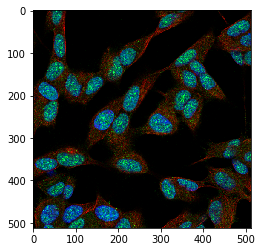

In [11]:
plt.imshow(train_images[30].px[:,:,:3])

In [12]:
train_images_combined = []
for p in tqdm_notebook(train_combined_images_paths):
    train_images_combined.append(open_numpy(p))

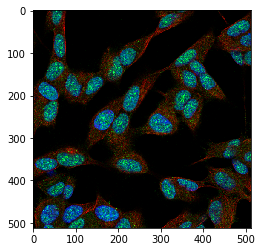

In [14]:
plt.imshow(train_images_combined[30].px[:, :, :3])

In [16]:
np.all(train_images_combined[30].px == train_images[30].px)

True